Анализ и подготовка плана действий по удержанию клиентов сети фитнес-центров «Культурист-датасаентист»

Отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.  
А именно: 
Спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
проанализировать основные признаки, наиболее сильно влияющие на отток;
сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
1) выделить целевые группы клиентов;
2) предложить меры по снижению оттока;
3) определить другие особенности взаимодействия с клиентами.

План исследования:
1. [Ознакомление с данными](#start)
    - [Загрузка данных](#1.1) 
    - [Изучение общей информации о датасетах](#1.2)
2. [Предобработка данных и исследовательский анализ](#preprocessing) 
    - [Изучение отдельных столбцов и предобработка](#2.1)
    - [Изучение средних значений признаков по группа ушли/остались](#2.2) 
    - [Графики распределения признаков по группам ушли/остались](#2.3)
    - [Построение матрицы корреляций](#1.1)
    - [Вывод по разделу](#1.1)
3. [Построение модели прогнозирования оттока клиентов ](#analitic)
    - [Разделение данных на обучающую и валидационную выборку ](#3.1) 
    - [Стандартизация](#3.2)
    - [Обучение модели логистической регрессией](#3.3)
    - [Обучение модели случайным лесом ](#3.4)
    - [Вывод по разделу](#3.5) 
4. [Кластеризация клиентов  ](#anal)
    - [Построение матрицы расстояний ](#4.1)
    - [Дендрограмма](#4.2) 
    - [Обучение модели кластеризации на основании алгоритма K-Means ](#4.3)
    - [Изучение значений признаков кластеров](#4.4)
    - [Графики распределения признаков кластеров](#4.5)
    - [Выводы о признаках кластерах](#4.6)
    - [Расчет доли оттока по кластерам](#4.7) 
5. [Вывод и рекомендации](#end)

<a id="start"></a>
Загрузим необходимые библиотеки

In [1]:
import pandas as pd
import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_colwidth', False)
pd.options.display.expand_frame_repr = False
#import warnings
#warnings.filterwarnings('ignore')  


<a id="1.1"></a>
Загрузим данные

In [2]:
# загружаем датафрейм
try:
    df = pd.read_csv('/datasets/gym_churn.csv')

except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/gym_churn.csv')
    

<a id="1.2"></a>
Посмотрим на наши данные, для этого используем функцию.

In [3]:
def show_info(data):
    display(data.head())
    
    # Описательные статистики для категориальных признаков
    cat_data = data.select_dtypes(include='object')
    for col in cat_data.columns:
        print(f"Уникальные значения для {col}: {data[col].unique()}")
    
    # Описательные статистики для числовых признаков
    num_data = data.select_dtypes(include=['int64', 'float64'])
    if not num_data.empty:
        display(num_data.describe().T)
    
    print(data.info())
    print("Проверка на пропуски:")
    display(data.isnull().sum())
    
    # Проверка на дубликаты
    print("Проверка на дубликаты:")
    if (duplicated := data.duplicated(keep=False)).any():
        some_duplicates = data[duplicated].sort_values(by=data.columns.to_list()).head()
        print(f"DataFrame содержит одну или несколько дублирующихся строк, например:\n{some_duplicates}")
    else:
        print("В DataFrame нет дублирующихся строк.")

In [4]:
show_info(df)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


,count,mean,std,min,25%,50%,75%,max
gender,"4,000.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
Near_Location,"4,000.00",0.85,0.36,0.00,1.00,1.00,1.00,1.00
Partner,"4,000.00",0.49,0.50,0.00,0.00,0.00,1.00,1.00
Promo_friends,"4,000.00",0.31,0.46,0.00,0.00,0.00,1.00,1.00
Phone,"4,000.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
Contract_period,"4,000.00",4.68,4.55,1.00,1.00,1.00,6.00,12.00
Group_visits,"4,000.00",0.41,0.49,0.00,0.00,0.00,1.00,1.00
Age,"4,000.00",29.18,3.26,18.00,27.00,29.00,31.00,41.00
Avg_additional_charges_total,"4,000.00",146.94,96.36,0.15,68.87,136.22,210.95,552.59
Month_to_end_contract,"4,000.00",4.32,4.19,1.00,1.00,1.00,6.00,12.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

Проверка на дубликаты:
В DataFrame нет дублирующихся строк.


Вывод по анализу результата describe()

- Gender (пол) :представлен 2-мя уникальными значениями 0 и 1, примерко в равном количестве
- Near_Location: представлен 2-мя уникальными значениями 0 и 1. Большинство клиентов (85%) находятся в близи к фитнес-центру
- Partner: представлен 2-мя уникальными значениями 0 и 1. Примерно половина клиентов пришла по партнерской программе.
- Promo_friends: представлен 2-мя уникальными значениями 0 и 1. Примерно 30% клиентов возпользовались программой Promo_friends.
- Phone: представлен 2-мя уникальными значениями 0 и 1. Большинство клиентов (90%) предоставили телефон для связи.
- Contract_period: Средний срок контракта составляет около 4.68 лет.
- Group_visits: Не все клиенты (41%) посещает групповые занятия.
- Age: Средний возраст клиентов составляет около 29 лет.
- Avg_additional_charges_total: Средние дополнительные сборы составляют около 146.94
- Month_to_end_contract: Средний оставшийся срок контракта составляет около 4.32 месяца.
- Lifetime: Средний период жизни клиента составляет около 3.72 года.
- Avg_class_frequency_total: Средняя частота посещения составляет около 1.88 раза.
- Avg_class_frequency_current_month: Средняя частота посещения в текущем месяце составляет около 1.77 раза.
- Churn: представлен 2-мя уникальными значениями 0 и 1. Примерно треть клиентов (27%) покинула компанию.

В данных не наблюдается аномальных значений выбросов.

<a id="preprocessing"></a> 
Предобработаем и изучим данные

<a id="2.1"></a>
Посмотрим на значения столбца с длительностью текущего действующего абонемента (месяц, 6 месяцев, год), выясним, какие абонементы преобладают.

In [5]:
df['Contract_period'].value_counts()

1     2207
12    960 
6     833 
Name: Contract_period, dtype: int64

Распределение по полу почти одинаково, только не понятно какое значение принадлежит какому полу.
- 85% клиентов живет или работает рядом с фитнес-клубом
- Около половины клиентов являются сотрудниками компании-партнёра клуба
- 31% клиентов пришли по программе "Приведи друга"
- 90% клиентов указали контактный телефон
- Длительность текущего действующего абонемента (месяц, 6 месяцев, год) - большинство абонементов на месяц
- 41% клиентов посещают групповые занятия
- Средний возраст клиентов 29 лет
- Средняя выручка от других услуг фитнес-центра - 146
- Средний срок до окончания договора - 4.3 месяцев
- Среднее время с момента первого обращения в фитнес-центр - 3.7 месяцев
- Средняя частота посещений в неделю за все время с начала действия абонемента - 1.87 раз в неделю
- Средняя частота посещений в неделю за предыдущий месяц - 1.76 раз в неделю
- Доля оттока - 27%

Приведем названия столбцов к нижнему регистру

In [6]:
df.columns = df.columns.str.lower()

Поработаем над типом данных. Приведем столбцы со значениями 1 и 0 к типу bool, а столбец 'Month_to_end_contract', в котором только целые значения, к типу int64

In [7]:
df[['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn' ]] = df[
    ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn' ]].astype(bool)

df[['month_to_end_contract']] = df[['month_to_end_contract']].astype('int64')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   bool   
 1   near_location                      4000 non-null   bool   
 2   partner                            4000 non-null   bool   
 3   promo_friends                      4000 non-null   bool   
 4   phone                              4000 non-null   bool   
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   bool   
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

<a id="2.2"></a>
Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался 

In [9]:
mean_values = df.groupby('churn').mean()
mean_values

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
False,0.51,0.87,0.53,0.35,0.90,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
True,0.51,0.77,0.36,0.18,0.90,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


Значения churn False - оставшиеся, True - ушедшие


<a id="2.3"></a>
Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

In [10]:
from sklearn.preprocessing import LabelEncoder

# Создаем экземпляр LabelEncoder

le = LabelEncoder()

# Применяем fit_transform к столбцу 'churn', чтобы преобразовать категориальные значения в числовые метки
# Результат сохраняется в новом столбце 'churn_encoded'

df['churn'] = le.fit_transform(df['churn'])

# Создаем подмножество данных, где 'churn_encoded' равен 1, что указывает на то, что клиент покинул компанию

churned = df[df['churn'] == 1]

# Создаем подмножество данных, где 'churn_encoded' равен 0, что указывает на то, что клиент остался

stayed = df[df['churn'] == 0]



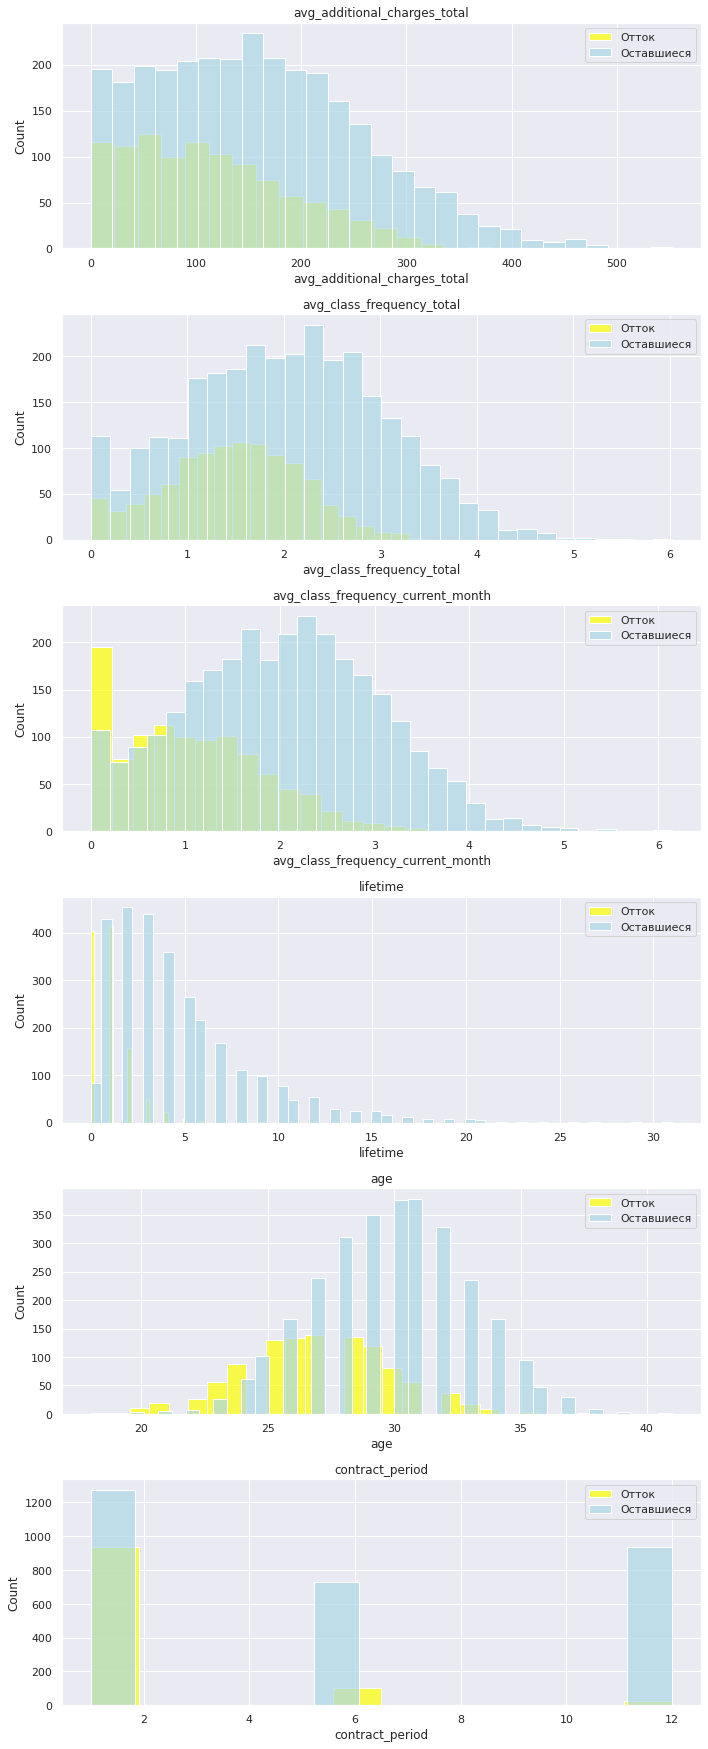

In [11]:
distplot_columns = ['avg_additional_charges_total', 'avg_class_frequency_total', 
                    'avg_class_frequency_current_month', 'lifetime', 'age', 
                    'contract_period', 'month_to_end_contract']

# Создание фигуры и осей для графиков
fig, axes = plt.subplots(len(distplot_columns), 1, figsize=(10, 4 * len(distplot_columns)))

for i, column in enumerate(distplot_columns):
    # Построение графика для ушедших
    sns.histplot(churned[column], ax=axes[i], label='Отток', color='yellow', alpha=0.7)
    
    # Построение графика для остававшихся
    sns.histplot(stayed[column], ax=axes[i], label='Оставшиеся', color='lightblue', alpha=0.7)
    
    # Добавление названия оси и заголовка
    axes[i].set_title(column)
    axes[i].legend(loc='upper right')

# Удаление последней оси, если количество признаков нечетное
if len(distplot_columns) % 2 != 0:
    fig.delaxes(axes[-1])

# Отображение графика

plt.tight_layout()
plt.show()

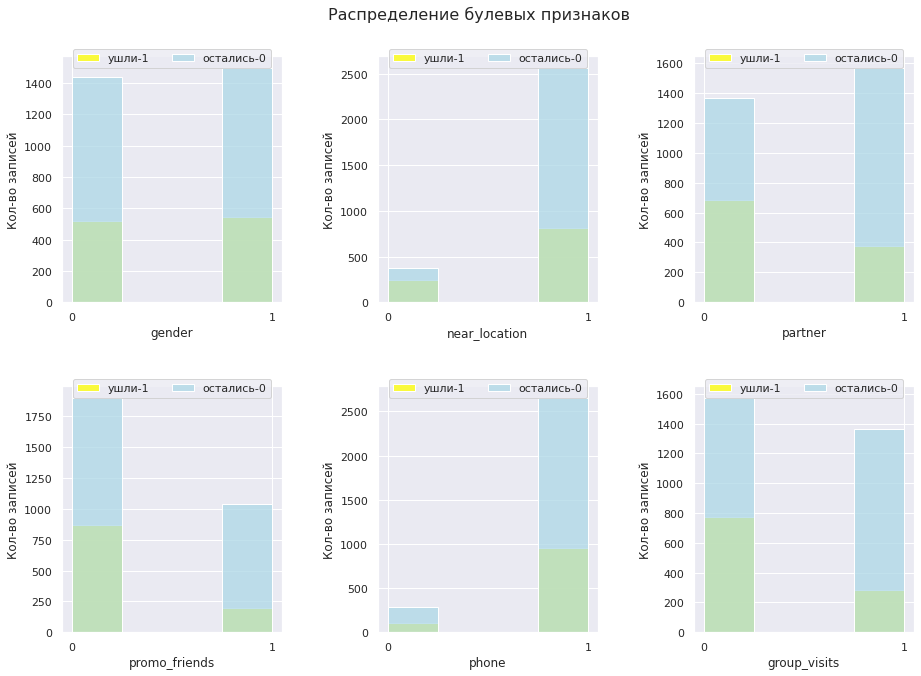

In [12]:
# Определение списка булевых признаков
bool_features = df.select_dtypes(include=[bool]).columns.tolist()

# Создание фигуры и осей для графиков
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 10))
fig.tight_layout(pad=5.0)
fig.suptitle('Распределение булевых признаков', fontsize=16)

# Итерация по всем подграфикам
for ax, feature in zip(axes.flat, bool_features):
    # Построение гистограммы для ушедших
    sns.histplot(df.query('churn == 1')[feature].astype(int), bins=4, ax=ax, kde=False, color='yellow', label='ушли-1')
    
    # Построение гистограммы для остававшихся
    sns.histplot(df.query('churn == 0')[feature].astype(int), bins=4, ax=ax, kde=False, color='lightblue', label='остались-0')
    
    # Настройка подграфика
    ax.set_xticks([0, 1])
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Кол-во записей', fontsize=12)
    
    # Расположение легенды посередине сверху у каждого графика
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.show()

1. По признаку пол среднее значение одинаково, значит в равной степени уходили как мужчины так и женщины
2. Проживание или работа рядом - тот кто близко живет, реже уходят в отток
3. Сотрудники компании-партнёра клуба реже уходят в отток
4. Пришедшие по акции "Приведи друга" - значительно реже, в 2 раза, уходят в отток
5. И те и те оставили свой контактый телефон в равной степени.
6. Клиенты с большим сроком абонемента реже уходили в отток
7. Оставшиеся пользователи чаще ходят на групповые занятия, чем ушедшие, почти в 2 раза
8. Средний возраст ушедших - 27 лет, оставшихся - 30 лет.
9. Ушедшие тратили на доп услуги 115, оставшиеся - 158.
10. У оставшихся клиентов в среднем длительный срок до окончания договора - более 5 месяцев, тогда как у ушедших в среднем оставалось полтора месяца.
11. Лайфтам ушедших пользователей - один месяц, а те, кто посещает более 5 месяцев - остаются.
12. Так же оставшиеся клиенты немного чаще посещали фитнес-центр, чем ушедшие
13. А в предыдущий месяц оставшиеся посещали занятия в 2 раза чаще, чем ушедшие.

<a id="2.4"></a>
Построим матрицу корреляций

Так как большинство наших признаков распределены не нормально,но больших выбросов в них мы не наблюдаем, для расчета коэфициентов корреляции будем использовать метод Спирмена.

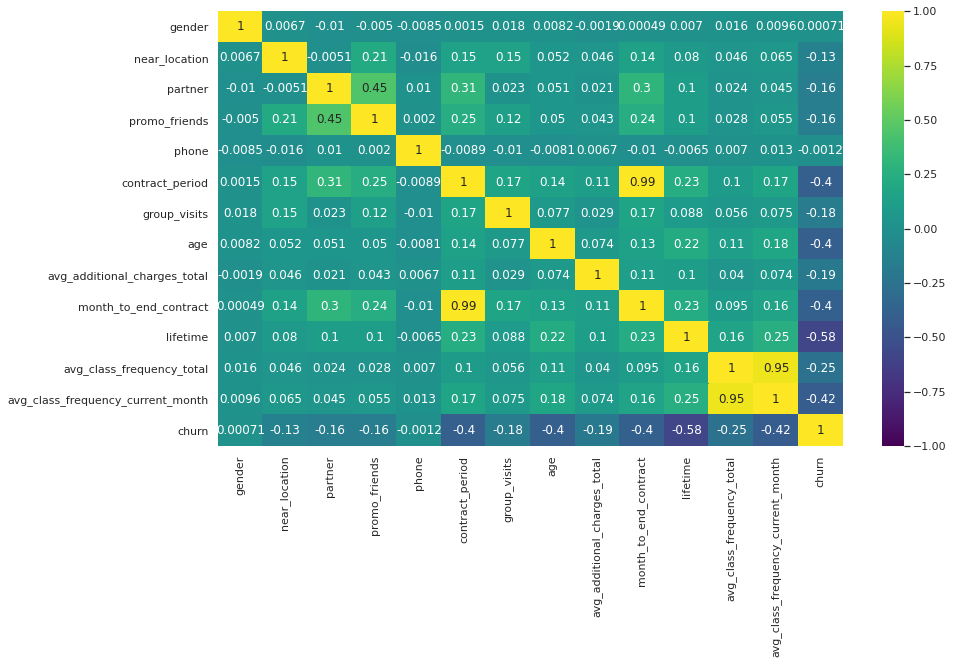

In [13]:
# Рассчитываем матрицу корреляций с использованием Спирмена
correlation_matrix = df.corr(method='spearman')

# Создание фигуры
plt.figure(figsize=(14, 8))

# Построение матрицы корреляций 
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', vmin=-1, vmax=1, center=0)
plt.show()

На карте между 'churn' и признаками видна отрицательная корреляция - значит, чем сильнее признак, тем слабее отток.
Можно отметить очень сильную (выше 0,95) корреляцию пар признаков
а) 'contract_period' и 'month_to_end_contract'- чем больше период абонемента, тем больше месяцев осталось до конца
б) 'avg_class_frequency_current_month' и 'avg_class_frequency_total' - то есть клиенты ходят на занятия с постоянным определенным графиком
Так же корелируют признаки 'partner' и 'promo_friends' с коэфициентом 0,45. И можно сказать, что по акциям клинты заключают контракт на более длительный период.

<a id="2.5"></a>
В ходе проведения исследователького анализа данных мы ознакомились с данными, привели типы данных в соответствие к их значениям, привели названия столбцов к нижнему регистру, выяснили, что в данных нет пропусков и дубликатов.
Так же мы изучили и проанализировали распределения признаков для ушедших и оставшихся клиентов. Вот некоторые выводы:
- средний возраст клиентов 29 лет,  ушедших - 27 лет, оставшихся — 30 лет
- большишиство клиентов живут или работают недалеко (85%), большинство ушедших живет не близко
- большинство клиентов приобретают абонемент на 1 месяц, и ушедшие клиенты так же чаще брали короткие абонементы на 1 месяц
- треть клинетов пришли по программе «Приведи друга»
- около половины клиентов являются сотрудниками компании-партнера клуба и они реже уходят в отток
- ушедшие клиенты очень редко посещали фитнес-клуб, и реже, чем оставшиесяходили на групповые занятия 
- ушедшие клиенты  меньше тратили денег на другие услуги фитнес-центра
- клиенты в основном прекращают пользоваться услугами фитнес-центра в последние полтора месяца действия абонемента
- Доля оттока клиентов составляет 27%

<a id="analitic"></a>
Шаг 3. Построим модель прогнозирования оттока клиентов

<a id="3.1"></a>
Разделим данные на обучающую и валидационную выборку 

In [14]:
# Разделение данных на признаки X и целевой признак y
X = df.drop('churn', axis=1)
y = df['churn']
# Разделение данных на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

Проверим размеры полученных выборок

In [15]:
# Проверка размеров и размерностей обучающей выборки
print("Размерность обучающей выборки:", X_train.shape)
print("Количество строк в обучающей выборке:", X_train.shape[0])
print("Количество столбцов в обучающей выборке:", X_train.shape[1])

# Проверка размеров и размерностей валидационной выборки
print("Размерность валидационной выборки:", X_val.shape)
print("Количество строк в валидационной выборке:", X_val.shape[0])
print("Количество столбцов в валидационной выборке:", X_val.shape[1])

Размерность обучающей выборки: (3200, 13)
Количество строк в обучающей выборке: 3200
Количество столбцов в обучающей выборке: 13
Размерность валидационной выборки: (800, 13)
Количество строк в валидационной выборке: 800
Количество столбцов в валидационной выборке: 13


Разбиение данных прошло нормально, размеры выборок соответствуют ожидаемым

<a id="3.2"></a>
Стандартизируем

In [16]:
# стандартизируем данные 
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.fit_transform(X_train)
X_val_st = scaler.transform(X_val)

<a id="3.3"></a>
Обучим модель на train-выборке логистической регрессией

In [17]:
from sklearn.metrics import roc_auc_score
# Обучение модели логистической регрессии
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_val_st)
lr_probabilities = lr_model.predict_proba(X_val_st)[:,1]
# Вывод метрик для модели логистической регрессии
print('Метрики для модели логистической регрессии:')
print('accuracy_score: {}\nprecision_score: {}\nrecall_score:{}'.format(
    accuracy_score(y_val, lr_predictions).round(3),
    precision_score(y_val, lr_predictions).round(3),
    recall_score(y_val, lr_predictions).round(3)))
# Вычисление и вывод ROC AUC
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_val, lr_probabilities)))

Метрики для модели логистической регрессии:
accuracy_score: 0.922
precision_score: 0.854
recall_score:0.828
ROC_AUC: 0.97


<a id="3.4"></a>
Обучим модель на train-выборке случайным лесом

In [18]:
# Обучение модели случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_val_st)
rf_probabilities = rf_model.predict_proba(X_val_st)[:,1]
# Вывод метрик для модели случайного леса
print('Метрики для модели случайного леса:')
print('accuracy_score: {}\nprecision_score: {}\nrecall_score:{}'.format(
    accuracy_score(y_val, rf_predictions).round(3),
    precision_score(y_val, rf_predictions).round(3),
    recall_score(y_val, rf_predictions).round(3)))
# Вычисление и вывод ROC AUC
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_val, rf_probabilities)))

Метрики для модели случайного леса:
accuracy_score: 0.915
precision_score: 0.839
recall_score:0.813
ROC_AUC: 0.97


<a id="3.5"></a>
Сравнивая эти метрики, можно заметить следующее:

Обе модели показывают очень высокие значения ROC AUC, что указывает на их хорошую способность различать между классами. Accuracy (точность) для модели логистической регрессии выше, чем для модели случайного леса. Это означает, что модель логистической регрессии лучше обобщает данные и делает более точные предсказания.
Precision (точность) для модели логистической регрессии также выше, что указывает на то, что модель лучше избегает ложных срабатываний, то есть количество истинно положительных результатов, которые модель правильно идентифицировала, выше.
Recall (полнота) для модели случайного леса выше, что означает, что модель лучше идентифицирует все положительные случаи, то есть количество истинно положительных результатов, которые модель смогла обнаружить, выше.
Исходя из этих данных, можно сделать вывод, что модель логистической регрессии показала лучшие результаты по метрикам accuracy и precision, что делает её более предпочтительной для данной задачи. Однако, если важнее обнаруживать все положительные случаи, то модель случайного леса может быть предпочтительнее благодаря более высокому значению recall.

Выбор между этими моделями зависит от конкретных требований к задаче. Если важнее избежать ложных срабатываний, то лучше выбрать модель логистической регрессии. Если же важнее обнаруживать все положительные случаи, то лучше выбрать модель случайного леса.

<a id="anal"></a> 
Шаг 4. Сделаем кластеризацию клиентов

In [19]:
# Отложим в сторону столбец с оттоком
df_no_churn = df.drop('churn', axis=1)

Стандартизируем данные.

In [20]:
scaler = StandardScaler()
df_no_churn_scaled = scaler.fit_transform(df_no_churn)

<a id="4.1"></a>
Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков 

In [21]:
# Построение матрицы расстояний
Z = linkage(df_no_churn_scaled, method='ward')
Z

array([[9.70000000e+01, 3.22200000e+03, 1.00990653e-01, 2.00000000e+00],
       [2.61000000e+02, 3.17900000e+03, 1.22634574e-01, 2.00000000e+00],
       [8.90000000e+02, 1.75000000e+03, 1.28123291e-01, 2.00000000e+00],
       ...,
       [7.98700000e+03, 7.99500000e+03, 8.38725499e+01, 2.65600000e+03],
       [7.98800000e+03, 7.99600000e+03, 8.89563592e+01, 3.03400000e+03],
       [7.99200000e+03, 7.99700000e+03, 1.04627601e+02, 4.00000000e+03]])

<a id="4.2"></a>
Нарисуем дендрограмму

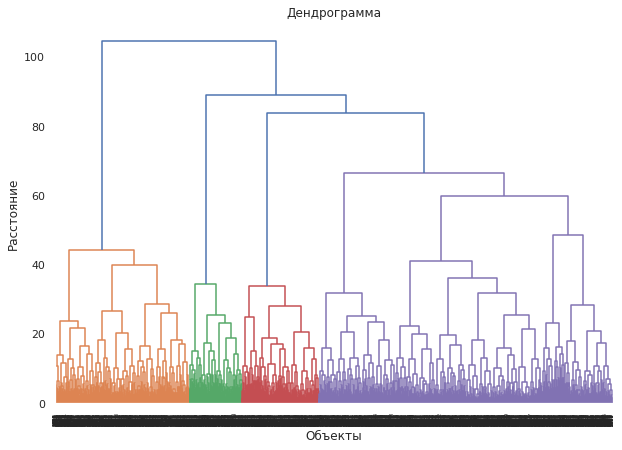

In [22]:
# Построение дендрограммы
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Дендрограмма')
plt.xlabel('Объекты')
plt.ylabel('Расстояние')
plt.show()

На основании полученного графика дендрограммы выделим 5 кластеров.

<a id="4.3"></a>
Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

In [23]:
# Обучение модели K-Means
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df_no_churn_scaled)

# Спрогнозирование кластеров клиентов
df['cluster'] = kmeans.labels_

<a id="4.4"></a>
Посмотрим на средние значения признаков для кластеров

In [24]:
# Средние значения признаков для каждого кластера
cluster_means = df.groupby('cluster').mean()
cluster_means

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.50,0.96,0.78,0.57,1.00,10.89,0.54,29.98,160.76,9.95,4.74,1.98,1.97,0.03
1,0.52,0.86,0.47,0.31,0.00,4.79,0.43,29.30,143.96,4.48,3.92,1.85,1.72,0.27
2,0.50,0.00,0.46,0.08,1.00,2.35,0.22,28.48,135.46,2.20,2.81,1.66,1.48,0.44
3,0.49,1.00,0.35,0.24,1.00,1.95,0.34,28.17,131.62,1.86,2.44,1.25,1.01,0.51
4,0.56,0.98,0.36,0.23,1.00,2.67,0.47,30.13,161.66,2.46,4.90,2.85,2.85,0.07


Что можем сразу заметить по средним значениям:
Для всех кластеров распределение по полу примерно одинаковое. Во втором кластере все клиенты живут/работают далеко от фитнес-центра. В первом кластере никто не оставил контактный номер телефона.  Самый высокий отток у 3 кластера, самый низкий у 0.


<a id="4.5"></a>
Построим графики распределения признаков для кластеров

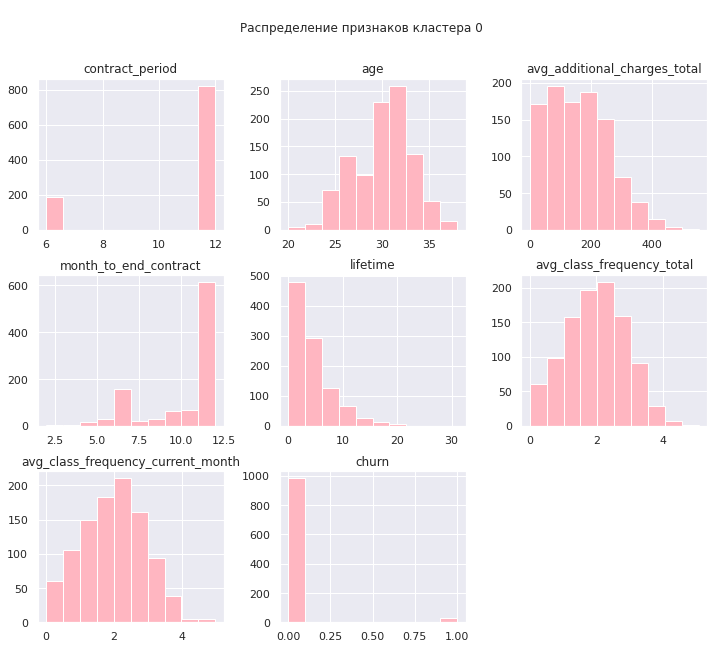

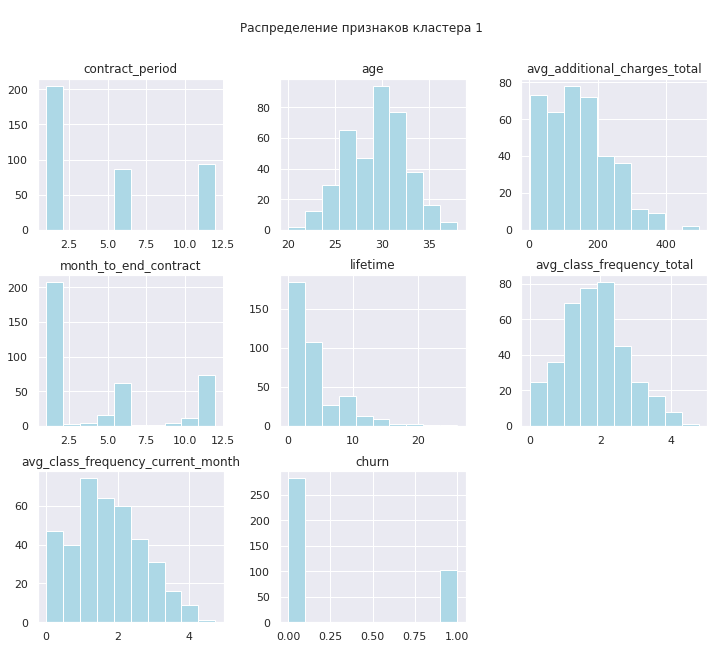

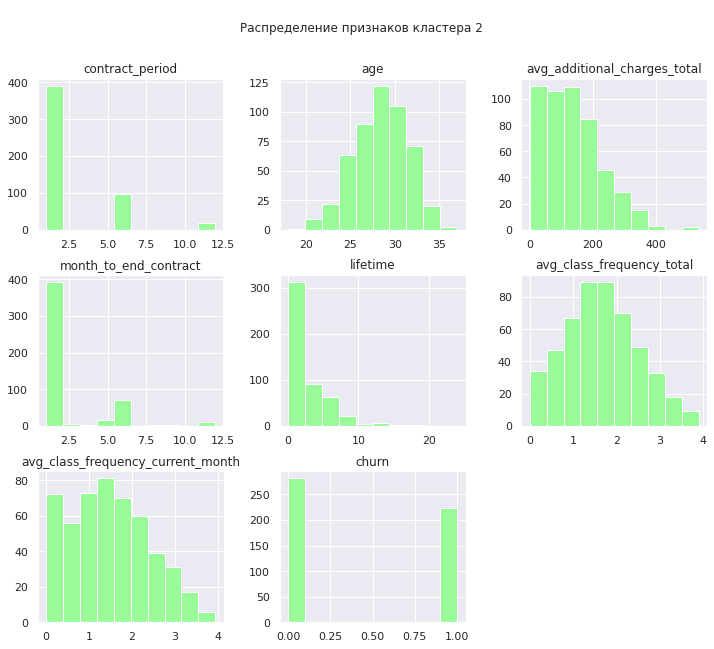

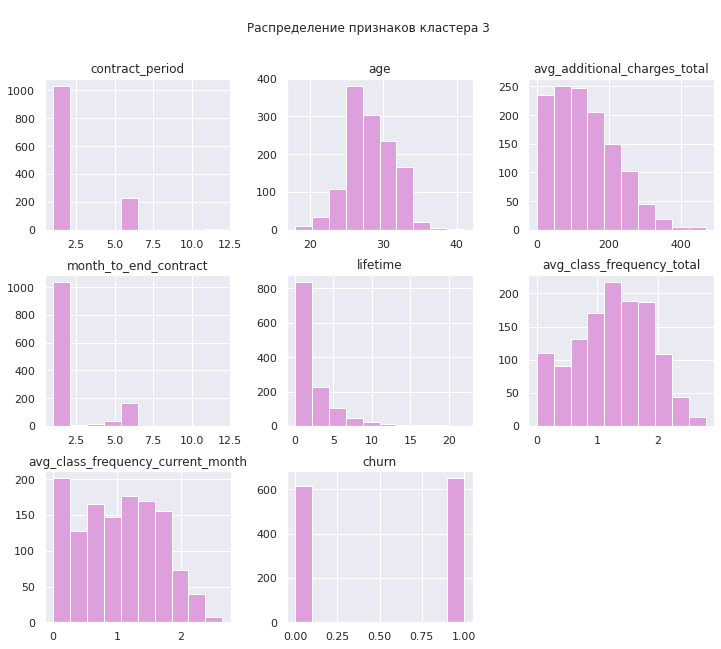

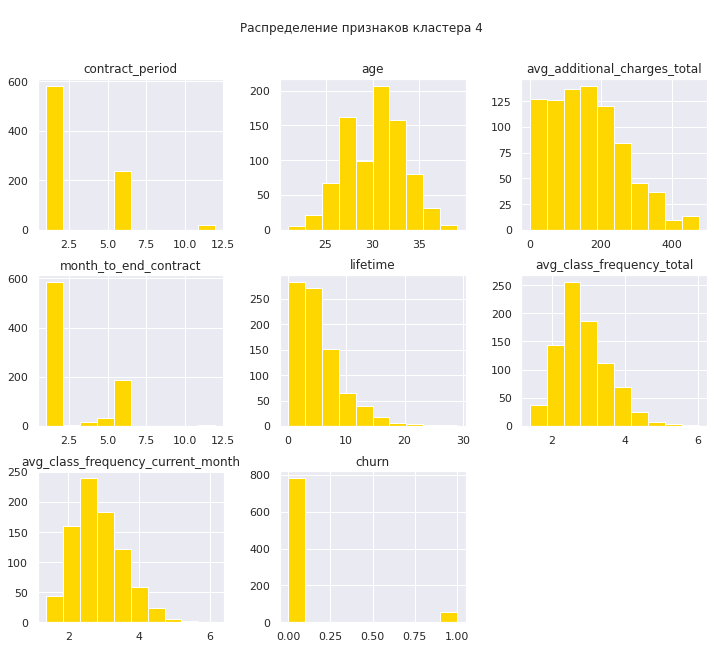

In [25]:
n_clusters = 5
colors = ['#FFB6C1', '#ADD8E6', '#98FB98', '#DDA0DD', '#FFD700']  # пастельные цвета для каждого кластера

for cluster in range(n_clusters):
    cluster_data = df[df['cluster'] == cluster].drop('cluster', axis=1)  # исключаем столбец 'cluster'
    cluster_data.hist(figsize=(12, 10), color=colors[cluster])  # устанавливаем пастельный цвет для текущего кластера
    plt.suptitle('\nРаспределение признаков кластера {}'.format(cluster), fontsize=12)
    plt.show()  

<a id="4.6"></a>
На основе средних значений и диаграмм распределения признаков кластеров сделаем следующие выводы о кластерах:

**Кластер 0**

- Проживают или работают рядом
- Пришли по партнерской или промо программе
- У всех указан телефон
- Большинство клиентов купили длительный абонемент на 12 месяцев, некоторые на 6 месяцев, но нет клиентов с абонементами на месяц
- Часто посещают групповые занятия
- Возраст в среднем 30 лет, но больше клинтов 32 лет
- Высокая выручка от доп услуг
- До конца абонемента более 9 месяцев, большинство клиентов недавно начали пользоваться абонементом.
- Самый высокий лайфтам, в среднем почти 5 месяцев
- Посещают примерно 2 раза в неделю постоянно
- Самый низкий показатель оттока

**Кластер 1**

- Проживают или работают рядом
- Половина клиентов по партнерской и треть по промо программе
- Ни у кого не указан телефон
- Большинство купили абонемент на 1 месяц, так жже покупали и на 6 и на 12. 
- Часто посещают групповые занятия
- Возраст в среднем 29 лет, но больше клиентов 30 лет
- Средняя выручка от доп услуг
- До конца абонемента более в большинстве случаев 1 месяц
- Лайфтам, в среднем почти 4 месяца
- Посещают примерно 2 раза в неделю постоянно
- Средний показатель оттока

**Кластер 2**

- Все живут/работают не близко от финтес-центра
- Половина клиентов по партнерской и почти нет по промо программе
- У всех указан телефон
- Чаще покупали абонемент на 1 месяц, есть те которые купили на 6 месяцев и совсем мало на 12. 
- Реже всех посещают групповые занятия
- Возраст в среднем 28,5 лет
- Средняя выручка от доп услуг
- До конца абонемента около 2 месяцев
- Лайфтам, в среднем почти 3 месяца
- Посещают примерно 1,5 раза в неделю постоянно
- Показатель оттока второй по величине

**Кластер 3**

- Все живут/работают близко с финтес-центром
- примерно треть клиентов по партнерской и одна четвертая по промо программе
- У всех указан телефон
- Чаще покупали абонемент на 1  месяц, иногда на 6
- Редко посещают групповые занятия
- Возраст в среднем 28 лет, но большинство клиентов 26 лет
- Самая низкая выручка от доп услуг
- До конца абонемента менее 2 месяцев
- Лайфтам, в среднем почти 2,5 месяца
- Реже всех посещают занятия
- Самый высокий отток

**Кластер 4**

- Почти все живут/работают близко с финтес-центром
- примерно треть клиентов по партнерской и одна четвертая по промо программе
- У всех указан телефон
- Чаще покупали абонемент на 1 или 6 месяцев , редко на 12
- Часто посещают групповые занятия
- Возраст в среднем 30 лет, больше клиентов 31-32 лет
- Самая высокая выручка от доп услуг
- До конца абонемента около 2,5 месяцев
- Лайфтам, в среднем почти 5 месяцев
- Чаще всех посещают занятия, почти 3 раза в неделю
- Самый низкий отток

<a id="4.7"></a>
Для каждого полученного кластера посчитаем долю оттока в процентах

In [26]:
# Доля оттока для каждого кластера от общего оттока
churn_share = df.query('churn==1').groupby('cluster')['churn'].count() / df.query('churn==1')['churn'].count()*100
churn_share 

cluster
0   2.64 
1   9.71 
2   21.11
3   61.17
4   5.37 
Name: churn, dtype: float64

Самая высокая доля оттока клиентов у 3 кластера, это кластер с самыми молодыми клиентами, которые чаще покупали абонемент на 1 месяц, реже всех посещали занятия и пользовались доп услугами. А самый надежный кластер с минимальной долей оттока - кластер 0, это кластер, клиенты которого воспользовали акцией при покупке абонемента, купили абонемент на длительный срок 12 месяцев, пользуются доп услугами и стабильно, примерно 2 раза в неделю посещают фитнес-клуб.

<a id="end"></a>
5. Выводы и рекомендации 

В данном проекте мы провели анализ оттока клиентов сети фитнес-клуба. 
Ознакомились с данными и провели исследователький анализ. Привели названия столбцов к нижнему региста, поменяли тип данных столбцов, где есть только два значения 0 и 1 на bool. Проверили на пропуски и дубликаты. Затем изучили средние значения. Описали характеристики признаков как:
- 85% клиентов живет или работает рядом с фитнес-клубом
- Около половины клиентов являются сотрудниками компании-партнёра клуба
- 31% клиентов пришли по программе "Приведи друга"
- 90% клиентов указали контактный телефон
- Длительность текущего действующего абонемента (месяц, 6 месяцев, год) - большинство абонементов на месяц
- 41% клиентов посещают групповые занятия
- Средний возраст клиентов 29 лет
- Средняя выручка от других услуг фитнес-центра - 146
- Средний срок до окончания договора - 4.3 месяцев
- Среднее время с момента первого обращения в фитнес-центр - 3.7 месяцев
- Средняя частота посещений в неделю за все время с начала действия абонемента - 1.87 раз в неделю
- Средняя частота посещений в неделю за предыдущий месяц - 1.76 раз в неделю
- Доля оттока — 27%

Затем разделили данные на 2 группы по признаку ушли ли в отток клиенты или нет, изучили распределения признаков в каждой группе, посмотрели как коррелируют признаки и сделали следующие выводы: 
- средний возраст клиентов 29 лет,  ушедших - 27 лет, оставшихся — 30 лет
- большишиство клиентов живут или работают недалеко (85%), большинство ушедших живет не близко
- большинство клиентов приобретают абонемент на 1 месяц, и ушедшие клиенты так же чаще брали короткие абонементы на 1 месяц
- треть клинетов пришли по программе «Приведи друга»
- около половины клиентов являются сотрудниками компании-партнера клуба и они реже уходят в отток
- ушедшие клиенты очень редко посещали фитнес-клуб, и реже, чем оставшиесяходили на групповые занятия 
- ушедшие клиенты  меньше тратили денег на другие услуги фитнес-центра
- клиенты в основном прекращают пользоваться услугами фитнес-центра в последние полтора месяца действия абонемента
- Доля оттока клиентов составляет 27%
Между показателем оттока и признаками видна отрицательная корреляция - значит, чем сильнее признак, тем слабее отток. Можно отметить очень сильную (выше 0,95) корреляцию пар признаков а) 'contract_period' и 'month_to_end_contract'- чем больше период абонемента, тем больше месяцев осталось до конца б) 'avg_class_frequency_current_month' и 'avg_class_frequency_total' - то есть клиенты ходят на занятия с постоянным определенным графиком Так же корелируют признаки 'partner' и 'promo_friends' с коэфициентом 0,45. И можно сказать, что по акциям клинты заключают контракт на более длительный период.

Далее мы построили модели прогнозирования оттока клиентов - логистической регрессии и случайного леса. Accuracy (точность) для модели логистической регрессии оказалась выше, чем для модели случайного леса. Значит модель логистической регрессии лучше обобщает данные и делает более точные предсказания.
Precision (точность) для модели логистической регрессии также выше, что указывает на то, что модель лучше избегает ложных срабатываний.
Recall (полнота) для модели случайного леса выше, что означает, что модель лучше идентифицирует все положительные случаи.
Исходя из этих данных, мы сделали вывод, что модель логистической регрессии показала лучшие результаты по метрикам accuracy и precision, что делает её более предпочтительной для данной задачи. 
Затем мы решали задачу кластеризации клиентов. На основе дендрограммы мы выделили 5 кластеров и на основе алгоритма  K-Means и спрогнозировали кластеры клиентов. Изучив распределение признаков по кластерам мы выявили характерные признаки для каждого кластера, выяснили, что самая высокая доля оттока клиентов у 3 кластера, это кластер с самыми молодыми клиентами, которые чаще покупали абонемент на 1 месяц, реже всех посещали занятия и пользовались доп услугами. А самый надежный кластер с минимальной долей оттока - кластер 0, это кластер, клиенты которого воспользовали акцией при покупке абонемента, купили абонемент на длительный срок 12 месяцев, пользуются доп услугами и стабильно, примерно 2 раза в неделю посещают фитнес-клуб.

**Рекомендации**

На основе проведенного анализа можем дать следующие рекомендации по удержанию клиентов сети фитнес-центров «Культурист-датасаентист»:
Стоит обратить внимание на низкий отток клиентов, которые приобретают абонементы на длительный срок 12 месяцев. Возможно стоит сделать еще более привлекательные условия по цене на длительный срок или включить в стоимость абонемента дополнительные услуги, направленные на более молодых клиентов, которые не склонны покупать абонемент на длительный срок, например пользование солярием или групповые виды спорта (баскетболл, футболл...).
Так же мы видим, что большинство клиентов воспользовались акциями при покупке абонементов, нужно рассмотреть количество и периодичность акций, расширив тем самым влияние на покупку абонементов разных категорий пользователей. 
